# LM05 with Decoy States: QKD Security Simulation in Python

This Colab notebook implements a **simulation of the LM05 two-way quantum key
distribution (QKD) protocol** enhanced with **decoy states**.

We model:

- Single-qubit LM05 protocol (message mode and control mode)
- Three intensity classes:
  - **Signal** (μ_signal)
  - **Weak decoy** (μ_decoy)
  - **Vacuum** (μ_vac)
- Two eavesdropping strategies:
  - **Photon-number-splitting (PNS) attack**
  - **Intercept–resend (IR) attack**

For each intensity class and attack model, we estimate:

- Yield (fraction of rounds with a detection in MM or CM)
- QBER (Quantum Bit Error Rate) in message mode
- Control-mode detection rate (probability that CM detects Eve)
- Key agreement rate (how often Bob’s decoded bit equals Alice’s bit)
- Fraction of key leaked to Eve (Eve’s information on the raw key)

This is a **conceptual security analysis** for LM05 + decoy states, not a
full finite-key security proof, but it captures the core qualitative behaviour:

- **IR attacks** → large QBER and CM detection
- **PNS attacks** → low QBER, but increased Eve information, especially for signal pulses


In [12]:

!pip install numpy matplotlib

In [13]:
# lm05_decoy_sim.py
# NumPy-based LM05 + decoy-state simulation with PNS and IR attacks.
# Author: (your name)
import numpy as np
import random
from collections import defaultdict, Counter

# ---- single-qubit basis states ----
zero = np.array([1.0, 0.0], dtype=complex)
one  = np.array([0.0, 1.0], dtype=complex)
plus = (zero + one) / np.sqrt(2)
minus= (zero - one) / np.sqrt(2)
Y = np.array([[0,-1j],[1j,0]], dtype=complex)

### Qubit Bases and Encoding in LM05

The LM05 protocol uses two **mutually unbiased bases (MUBs)** for qubit
preparation and measurement:

- **Z basis**:  
  $|0\rangle,\ |1\rangle$

- **X basis**:  
  $|+\rangle,\ |-\rangle$  
  where
  $$
  |+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}, \qquad
  |-\rangle = \frac{|0\rangle - |1\rangle}{\sqrt{2}}.
  $$

In message mode, Alice encodes her classical bit using two unitary
operations:

- Alice’s bit **0** → apply the **Identity** operation $I$
- Alice’s bit **1** → apply the **Pauli-Y encoding** $iY$

The Pauli-$Y$ operator is given by
$$
Y =
\begin{pmatrix}
0 & -i \\
i & 0
\end{pmatrix}.
$$

This choice of encoding ensures that Bob can deterministically decode
Alice’s bit by measuring the returned qubit in the same basis used during
state preparation.


- **`prepare_state(bit, basis)`**  
  Encodes a classical bit into a quantum state in the chosen basis.
### Function Descriptions

#### `prepare_state(bit, basis)`

Encodes a **classical bit** (`0` or `1`) into a **quantum state** using the selected basis.

- If `basis = "Z"`:
  - `0 → |0⟩`
  - `1 → |1⟩`

- If `basis = "X"`:
  - `0 → |+⟩ = (|0⟩ + |1⟩)/√2`
  - `1 → |−⟩ = (|0⟩ − |1⟩)/√2`

---

#### `measure_and_collapse(state, basis)`

Simulates an **ideal projective measurement** on a single-qubit quantum state.

- **Z basis measurement**:
  - Projects the state onto `|0⟩` or `|1⟩`

- **X basis measurement**:
  - Projects the state onto `|+⟩` or `|−⟩`

The function:
- Randomly samples a measurement outcome according to quantum probabilities
- Collapses the quantum state to the corresponding eigenstate

**Returns:**
- The classical measurement outcome (`0` or `1`)
- The post-measurement (collapsed) quantum state

---

#### `apply_iY(state)`

Applies the **`iY` unitary operator** to a single-qubit quantum state.

- Used in the **LM05 protocol** to encode **logical bit `1`**
- The operation transforms the state as:

\[
iY =
\begin{pmatrix}
0 & 1 \\
-1 & 0
\end{pmatrix}
\]

- For an input state  
  \[
  |\psi⟩ = \alpha|0⟩ + \beta|1⟩
  \]
  the result is:
  \[
  iY|\psi⟩ = \beta|0⟩ - \alpha|1⟩
  \]

---


- **`measure_and_collapse(state, basis)`**  
  Simulates an ideal projective measurement:  
  - In **Z basis** → projects onto \- In **Z basis** → projects onto \- In **Z basis** → projects onto \(|0\rangle\), \(|1\rangle\)  
- In **X basis** → projects onto \(|+\rangle\), \(|-\rangle\)

  
  and returns both the measurement outcome and the post-measurement state.

- **`apply_iY(state)`**  
  Implements the **\( iY \)** unitary (LM05 encoding for bit `1`).


In [14]:
# ---- helpers ----
def prepare_state(bit, basis):
    if basis == 'Z':
        return zero.copy() if bit == 0 else one.copy()
    elif basis == 'X':
        return plus.copy() if bit == 0 else minus.copy()
    else:
        raise ValueError("basis must be 'Z' or 'X'")

def measure_and_collapse(state, basis):
    """Projective measurement in basis; returns (outcome, post-state)"""
    if basis == 'Z':
        p0 = abs(np.vdot(zero, state))**2
        p1 = 1 - p0
        r = random.random()
        if r < p0:
            return 0, zero.copy()
        else:
            return 1, one.copy()
    else:
        p0 = abs(np.vdot(plus, state))**2
        r = random.random()
        if r < p0:
            return 0, plus.copy()
        else:
            return 1, minus.copy()

def apply_iY(state):
    return 1j * (Y @ state)

### Decoy-State and Channel Parameters

#### Three-Intensity Decoy-State Scheme

We implement a **three-intensity decoy-state scheme** with the following mean photon numbers:

- **Signal pulses:** μ = 0.6  
- **Weak decoy pulses:** μ = 0.2  
- **Vacuum pulses:** μ = 0.0  

Each emitted pulse contains a **Poisson-distributed number of photons** with mean value μ.

---

#### Intensity Selection (`MU_WEIGHTS`)

`MU_WEIGHTS` controls how frequently each intensity level is selected.

Example:
- 60% → signal pulses  
- 30% → weak decoy pulses  
- 10% → vacuum pulses  

This randomized selection is essential for detecting photon-number–splitting (PNS) attacks.

---

#### Channel and Detection Efficiency (`ETA`)

`ETA` models the **combined channel and detector efficiency**.

- Forward and backward channels are merged into a **single effective survival probability**
- The probability of successful transmission depends on the number of photons arriving back at Alice

(This is a simplified loss model.)

---

#### Control Mode Probability (`P_CONTROL`)

`P_CONTROL` is the probability that **Alice chooses Control Mode (CM)** instead of Message Mode (MM).

- **Control Mode (CM):**  
  Used for error estimation and eavesdropping detection

- **Message Mode (MM):**  
  Used for key generation via encoding operations

Random switching between CM and MM ensures protocol security.

---


In [15]:
# ---- decoy params and channel ----
MU_SIGNAL = 0.6    # signal mean photon number
MU_DECOY  = 0.2    # weak decoy
MU_VAC    = 0.0    # vacuum
MU_CHOICES = [('signal', MU_SIGNAL), ('decoy', MU_DECOY), ('vacuum', MU_VAC)]
MU_WEIGHTS = {'signal': 0.6, 'decoy': 0.3, 'vacuum': 0.1}

ETA = 0.9  # per-pass survival prob for each photon (forward and return treated by independent survival of photons)

P_CONTROL = 0.25  # probability Alice chooses Control Mode

### Core Simulation Flow (Main Loop)

This section describes the **heart of the simulation**, showing how one complete protocol round is executed.

---

#### 1. Bob’s Preparation

Bob randomly chooses:
- A classical bit `bob_bit` from `{0, 1}`
- A preparation basis `bob_basis` from `{Z, X}`

He prepares the corresponding single-qubit quantum state and sends it forward.

---

#### 2. Photon Number Generation

A pulse with mean photon number `μ` is emitted.

- The actual photon number `n` is sampled from a **Poisson distribution**:
  - `n ~ Poisson(μ)`

---

#### 3. Eve on the Forward Channel

Eve may apply one of the following attacks:

- **Photon Number Splitting (PNS):**
  - If `n >= 2`, Eve keeps one photon and forwards `n - 1` photons

- **Intercept-Resend (IR):**
  - Eve measures the qubit in a random basis
  - She resends the collapsed quantum state

- **None:**
  - Eve does nothing and forwards the pulse unchanged

---

#### 4. Alice’s Operation Mode

Alice randomly selects one of two modes:

- **Control Mode (CM):**
  - Alice measures the incoming qubit using a random basis
  - The measured qubit is discarded
  - Alice prepares and sends back a fresh random quantum state

- **Message Mode (MM):**
  - Alice encodes a random bit:
    - `0` → apply identity operation `I`
    - `1` → apply `iY` operation

---

#### 5. Eve on the Return Channel

On the backward path, Eve may extract information:

- **PNS attack:**
  - If Eve previously stored a photon and Alice used MM
  - Eve perfectly learns Alice’s encoded bit

- **IR attack:**
  - Eve has a 50% probability of learning Alice’s bit
  - (Simplified information model)

---

#### 6. Loss on Return Channel

Photon loss is applied on the return path.

- Loss depends on:
  - The number of forwarded photons `n_forward`
  - The channel efficiency `ETA`

---

#### 7. Bob’s Measurement and Decision

Bob measures the returning qubit using his **original preparation basis**.

- **Message Mode (MM):**
  - Alice’s bit is decoded as:
    - `alice_bit = (bob_outcome != bob_bit)`

- **Control Mode (CM):**
  - If Bob’s result disagrees with Alice’s prepared bit
  - The event is counted as an **eavesdropping detection**

---


In [16]:
# ---- attack models ----
# 'none' : no Eve
# 'pns'  : photon-number-splitting (steal 1 photon if n>=2 on forward, measure stored photon later to learn MM)
# 'ir'   : intercept-resend (measure in random basis, resend collapsed photon -> causes disturbance)
# Note: these are simplified, illustrative models.

def simulate_round(mu, attack='none'):
    """Simulate one round for a given mu and attack strategy.
       Returns dict describing outcome type and relevant info.
    """
    # Bob prepares
    bob_basis = random.choice(['Z','X'])
    bob_bit   = random.choice([0,1])
    # sample number of photons (Poisson)
    n = np.random.poisson(mu)

    if n == 0:
        return {'type':'vacuum'}  # nothing goes through

    # Forward Eve actions
    eve_has_stored = False
    if attack == 'pns':
        if n >= 2:
            eve_has_stored = True
            n_forward = n - 1
        else:
            n_forward = n
    elif attack == 'ir':
        # Eve measures one photon in random basis and resends collapsed photon
        # We model effect below by collapsing the state
        n_forward = 1
    else:
        n_forward = n

    # Represent the traveling photon as a single-qubit state (all photons identical)
    state = prepare_state(bob_bit, bob_basis)

    if attack == 'ir':
        e_basis = random.choice(['Z','X'])
        e_out, collapsed = measure_and_collapse(state, e_basis)
        state = collapsed.copy()  # Eve resends collapsed photon

    # Alice chooses mode
    if random.random() < P_CONTROL:
        # Control mode: Alice measures in random basis and prepares a fresh random state in that basis
        a_basis = random.choice(['Z','X'])
        a_outcome, _ = measure_and_collapse(state, a_basis)
        # prepare fresh state to return
        a_prep_bit = random.choice([0,1])
        send_state = prepare_state(a_prep_bit, a_basis)
        mode = 'CM'
        alice_info = {'a_basis':a_basis, 'a_out':a_outcome, 'a_prep_bit':a_prep_bit}
    else:
        # Message mode: encode using I (0) or iY (1)
        a_bit = random.choice([0,1])
        if a_bit == 0:
            send_state = state.copy()
        else:
            send_state = apply_iY(state)
        mode = 'MM'
        alice_info = {'a_bit':a_bit}

    # Eve on return:
    eve_learn = None
    if attack == 'pns' and eve_has_stored:
        # If Eve stored a photon, in our simple model she can learn Alice's bit for MM rounds without disturbing Bob
        if mode == 'MM':
            eve_learn = {'method':'pns', 'learns_alice_bit': True}
    elif attack == 'ir':
        # IR gives partial info; simplification: she may have 50% chance to learn Alice bit
        if mode == 'MM':
            eve_learn = {'method':'ir', 'learns_alice_bit': (random.random()<0.5)}

    # Loss on return: survival prob that at least one of n_forward photons makes it back:
    if n_forward == 0:
        return {'type':'loss'}
    survive_prob = 1 - (1-ETA)**n_forward
    if random.random() > survive_prob:
        return {'type':'loss'}

    # Bob measures returned photon in his original basis
    bob_outcome, _ = measure_and_collapse(send_state, bob_basis)

    if mode == 'MM':
        # decoding: in LM05, if Alice applied I, Bob_outcome == bob_bit; if iY applied, Bob_outcome != bob_bit
        recovered_a_bit = int(bob_outcome != bob_bit)
        leak = 1 if (eve_learn and eve_learn.get('learns_alice_bit')) else 0
        return {'type':'MM', 'alice_bit': alice_info['a_bit'], 'bob_recovered':recovered_a_bit, 'leak':leak}
    else:
        # CM: detection if bob_outcome != alice prepared bit
        detect = int(bob_outcome != alice_info['a_prep_bit'])
        return {'type':'CM', 'detect': detect}

### `run_trials` Function Output

The `run_trials` function simulates **many protocol rounds** and stores **raw statistical counts** separately for each intensity level.

The collected metrics are:

- **rounds**  
  Total number of simulated rounds for this intensity.

- **mm_total**  
  Number of rounds operated in **Message Mode (MM)**.

- **mm_errors**  
  In MM, the number of times Bob decoded the **wrong bit**.

- **cm_total**  
  Number of rounds operated in **Control Mode (CM)**.

- **cm_detects**  
  In CM, the number of rounds where Bob observed a **mismatch**, indicating possible eavesdropping.

- **key_len**  
  Total number of key bits generated.

- **key_agree**  
  Number of key bits on which **Alice and Bob agree**.

- **leaked**  
  Number of key bits **known to Eve** (under the simplified attack model).

- **loss**  
  Number of rounds lost due to **channel transmission loss**.

- **vacuum**  
  Number of rounds corresponding to **true vacuum events**.

---


In [17]:
def run_trials(n_rounds=20000, attack='none'):
    totals = {k: defaultdict(int) for k,_ in MU_CHOICES}  # stats per mu class
    # choose mu weighted
    weights = [MU_WEIGHTS[name] for name,_ in MU_CHOICES]
    names = [name for name,_ in MU_CHOICES]
    for _ in range(n_rounds):
        cls = random.choices(names, weights=weights, k=1)[0]
        mu = dict(MU_CHOICES)[cls]
        totals[cls]['rounds'] += 1
        res = simulate_round(mu, attack=attack)
        if res['type'] == 'MM':
            totals[cls]['mm_total'] += 1
            totals[cls]['key_len'] += 1
            if res['bob_recovered'] != res['alice_bit']:
                totals[cls]['mm_errors'] += 1
            else:
                totals[cls]['key_agree'] += 1
            totals[cls]['leaked'] += res['leak']
        elif res['type'] == 'CM':
            totals[cls]['cm_total'] += 1
            totals[cls]['cm_detects'] += res['detect']
        elif res['type'] == 'loss':
            totals[cls]['loss'] += 1
        elif res['type'] == 'vacuum':
            totals[cls]['vacuum'] += 1
    return totals

### Derived Metrics (Per Intensity Class)

For each intensity class (**signal**, **decoy**, **vacuum**), the following metrics are computed from the raw counts.

- **yield**  
  (MM rounds + CM rounds) / total rounds  
  Indicates the overall probability that a pulse is successfully detected.

- **QBER**  
  mm_errors / mm_total  
  Measures how noisy the generated key is.

- **CM_detect_rate**  
  cm_detects / cm_total  
  Indicates how often Control Mode flags the presence of an eavesdropper.

- **key_agreement_rate**  
  Fraction of generated key bits where Alice and Bob agree.

- **leaked_frac**  
  Fraction of key bits known by Eve under the simplified attack model.

---

These metrics allow direct comparison of the following scenarios:
- No Eve
- Photon Number Splitting (PNS) Eve
- Intercept–Resend (IR) Eve

Results from different intensity classes can be analyzed side-by-side.
---


In [18]:
def summarize(totals):
    summary = {}
    for cls,_ in MU_CHOICES:
        t = totals[cls]
        mm_total = t.get('mm_total', 0)
        cm_total = t.get('cm_total', 0)
        key_len  = t.get('key_len', 0)
        summary[cls] = {
            'rounds': t.get('rounds',0),
            'yield': (mm_total + cm_total) / t.get('rounds',1),
            'mm_total': mm_total,
            'mm_errors': t.get('mm_errors',0),
            'QBER': (t.get('mm_errors',0)/mm_total) if mm_total>0 else 0.0,
            'cm_total': cm_total,
            'cm_detects': t.get('cm_detects',0),
            'CM_detect_rate': (t.get('cm_detects',0)/cm_total) if cm_total>0 else 0.0,
            'key_len': key_len,
            'key_agreement_rate': (t.get('key_agree',0)/key_len) if key_len>0 else 0.0,
            'leaked_frac': (t.get('leaked',0)/key_len) if key_len>0 else 0.0
        }
    return summary

## Running QKD Attack Simulations (No Eve, PNS Eve, IR Eve)

The code below runs three types of QKD simulations using `run_trials()`:

1. **No Eve (honest channel)**  
2. **PNS Attack (Photon Number Splitting)**  
3. **IR Attack (Intercept–Resend)**  

For each scenario, the simulation:
- Generates a large number of rounds  
- Calculates detection rates, QBER, yields, and leaked information  
- Summarizes results per intensity type (signal, decoy, vacuum)

The printed summaries help compare how different attacks affect:
- Error rates  
- Key agreement  
- Information leakage  
- Successful detection of Eve  


In [19]:



# Example runner when imported or called
if __name__ == '__main__':
    random.seed(0); np.random.seed(0)
    totals_none = run_trials(20000, attack='none')
    totals_pns  = run_trials(20000, attack='pns')
    totals_ir   = run_trials(20000, attack='ir')
    import json, pprint
    print("No Eve:\n"); pprint.pprint(summarize(totals_none))
    print("\nPNS Eve:\n"); pprint.pprint(summarize(totals_pns))
    print("\nIR Eve:\n"); pprint.pprint(summarize(totals_ir))

# Run experiments
tot_none = run_trials(30000, attack='none')
tot_pns  = run_trials(30000, attack='pns')
tot_ir   = run_trials(30000, attack='ir')

s_none = summarize(tot_none)
s_pns  = summarize(tot_pns)
s_ir   = summarize(tot_ir)

print("Summary (no Eve):", s_none)
print("Summary (PNS):", s_pns)
print("Summary (IR):", s_ir)



No Eve:

{'decoy': {'CM_detect_rate': 0.264,
           'QBER': 0.0,
           'cm_detects': 66,
           'cm_total': 250,
           'key_agreement_rate': 1.0,
           'key_len': 755,
           'leaked_frac': 0.0,
           'mm_errors': 0,
           'mm_total': 755,
           'rounds': 5923,
           'yield': 0.16967752827958804},
 'signal': {'CM_detect_rate': 0.23524656426839127,
            'QBER': 0.0,
            'cm_detects': 291,
            'cm_total': 1237,
            'key_agreement_rate': 1.0,
            'key_len': 3734,
            'leaked_frac': 0.0,
            'mm_errors': 0,
            'mm_total': 3734,
            'rounds': 12050,
            'yield': 0.4125311203319502},
 'vacuum': {'CM_detect_rate': 0.0,
            'QBER': 0.0,
            'cm_detects': 0,
            'cm_total': 0,
            'key_agreement_rate': 0.0,
            'key_len': 0,
            'leaked_frac': 0.0,
            'mm_errors': 0,
            'mm_total': 0,
            'rounds'

## Quantum Bit Error Rate (QBER) vs Intensity Class

This plot shows the **Quantum Bit Error Rate (QBER)** for each intensity class
(**signal**, **decoy**, and **vacuum**) under different attack scenarios.

**Interpretation:**

- **No Eve:**  
  QBER remains very low for all intensities, arising only from statistical
  fluctuations and measurement randomness.

- **Intercept–Resend (IR) attack:**  
  QBER increases significantly, especially for signal and decoy pulses.
  This is because Eve measures in a random basis, causing frequent
  basis mismatches and strong disturbance.

- **Photon-Number-Splitting (PNS) attack:**  
  QBER stays close to the no-Eve case, since PNS does not directly disturb
  the polarization encoding.

This demonstrates that **QBER is an effective indicator for detecting IR attacks**
but is insufficient on its own to detect PNS attacks.


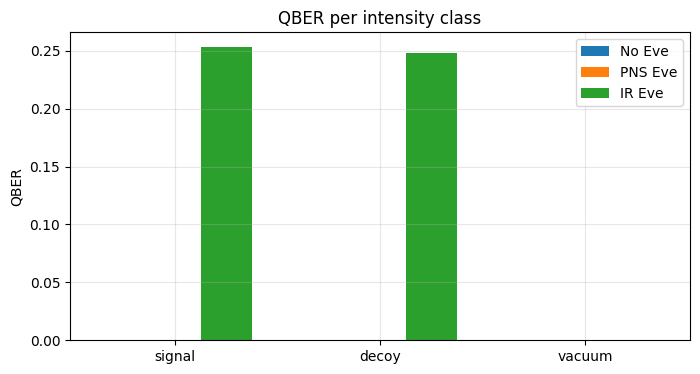

In [20]:
#from lm05_decoy_sim import run_trials, summarize, MU_CHOICES
import matplotlib.pyplot as plt

# Prepare bar plots per mu class
labels = [name for name,_ in MU_CHOICES]
x = range(len(labels))
# QBER
qber_none = [s_none[c]['QBER'] for c in labels]
qber_pns  = [s_pns[c]['QBER'] for c in labels]
qber_ir   = [s_ir[c]['QBER'] for c in labels]

plt.figure(figsize=(8,4))
width=0.25
plt.bar([i-width for i in x], qber_none, width=width, label='No Eve')
plt.bar([i for i in x], qber_pns, width=width, label='PNS Eve')
plt.bar([i+width for i in x], qber_ir, width=width, label='IR Eve')
plt.xticks(x, labels)
plt.ylabel('QBER')
plt.title('QBER per intensity class')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Control-Mode Detection Rate vs Intensity Class

This plot shows the **probability that control-mode (CM) rounds detect
eavesdropping** for each intensity class.

**Interpretation:**

- **No Eve:**  
  The control-mode detection rate remains very low, reflecting only random
  coincidences and imperfections.

- **Intercept–Resend (IR) attack:**  
  The detection rate in CM is significantly higher, since Eve’s measurements
  disturb the quantum state and lead to incorrect correlations.

- **Photon-Number-Splitting (PNS) attack:**  
  The CM detection rate is nearly identical to the no-Eve case, because PNS
  attacks do not disturb the polarization of single-photon pulses.

This confirms that **control-mode testing is effective against IR attacks**
but must be combined with decoy-state analysis to detect PNS attacks.


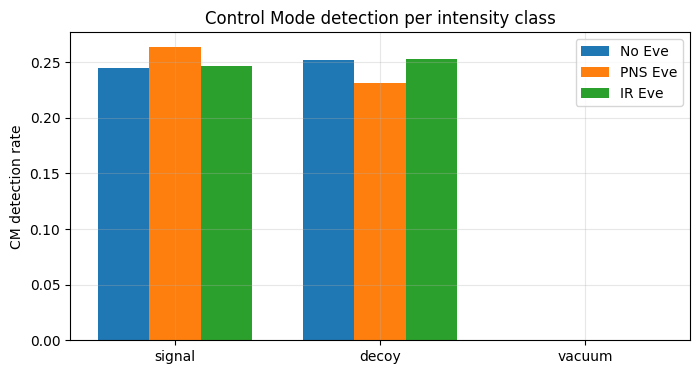

In [21]:
# CM detection
cm_none = [s_none[c]['CM_detect_rate'] for c in labels]
cm_pns  = [s_pns[c]['CM_detect_rate'] for c in labels]
cm_ir   = [s_ir[c]['CM_detect_rate'] for c in labels]

plt.figure(figsize=(8,4))
plt.bar([i-width for i in x], cm_none, width=width, label='No Eve')
plt.bar([i for i in x], cm_pns, width=width, label='PNS Eve')
plt.bar([i+width for i in x], cm_ir, width=width, label='IR Eve')
plt.xticks(x, labels)
plt.ylabel('CM detection rate')
plt.title('Control Mode detection per intensity class')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Eve’s Information vs Intensity Class

This plot shows the **fraction of key bits leaked to Eve** for signal, decoy,
and vacuum pulses.

**Interpretation:**

- **No Eve:**  
  The leaked fraction is approximately zero for all intensity classes.

- **Photon-Number-Splitting (PNS) attack:**  
  Eve’s information is highest for **signal pulses** and significantly lower
  for **decoy pulses**.
  This intensity dependence arises because multi-photon events occur more
  frequently at higher mean photon numbers.

- **Intercept–Resend (IR) attack:**  
  Eve gains partial information, but at the cost of introducing large errors,
  which are detected via QBER.

This plot illustrates the key idea of the **decoy-state method**:
PNS attacks are revealed by **statistical differences between signal and decoy
intensities**, rather than by increased error rates.


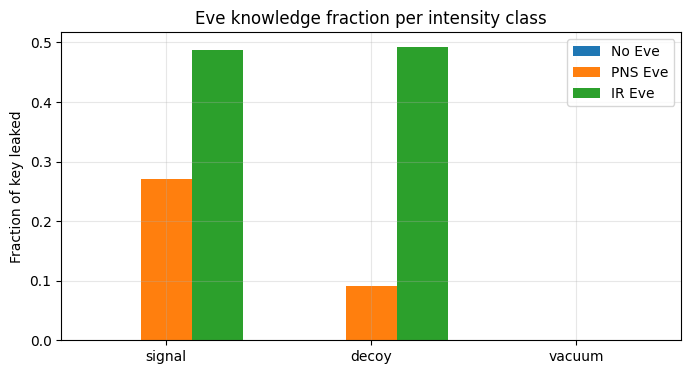

In [22]:




# Leakage
leak_none = [s_none[c]['leaked_frac'] for c in labels]
leak_pns  = [s_pns[c]['leaked_frac'] for c in labels]
leak_ir   = [s_ir[c]['leaked_frac'] for c in labels]

plt.figure(figsize=(8,4))
plt.bar([i-width for i in x], leak_none, width=width, label='No Eve')
plt.bar([i for i in x], leak_pns, width=width, label='PNS Eve')
plt.bar([i+width for i in x], leak_ir, width=width, label='IR Eve')
plt.xticks(x, labels)
plt.ylabel('Fraction of key leaked')
plt.title('Eve knowledge fraction per intensity class')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## ✅ Overall Conclusion

In this notebook, we implemented and analyzed the **LM05 two-way quantum key
distribution protocol** enhanced with **decoy states**, and studied its
security against two important eavesdropping strategies: **intercept–resend
(IR)** and **photon-number-splitting (PNS)** attacks.

From the **Eve knowledge fraction plot**, we observe that in the absence of
an eavesdropper, the leaked key fraction is essentially zero for all intensity
classes. Under a **PNS attack**, Eve’s information is significantly higher for
**signal pulses** than for **decoy pulses**, reflecting the increased
probability of multi-photon emissions at higher mean photon numbers. In
contrast, the **IR attack** leads to a high and nearly intensity-independent
information gain for Eve, approaching the value expected from random
measurement strategies.

The **control-mode detection plot** demonstrates the complementary role of
control mode in security. While the detection rate remains close to its
baseline value in the no-Eve and PNS scenarios, it is noticeably higher for
the IR attack. This confirms that intercept–resend attacks introduce strong
disturbances that can be effectively detected through control-mode testing,
whereas PNS attacks largely evade detection in this mode.

From the **QBER plot**, we find that the IR attack produces a large QBER
(around the characteristic \(25\%\) level), clearly distinguishing it from
honest operation. In contrast, the QBER under a PNS attack remains close to
the no-Eve case, demonstrating that error-rate monitoring alone is
insufficient to detect photon-number-based attacks.

Together, these results highlight the **key advantage of combining decoy
states with the LM05 protocol**. QBER and control-mode statistics reliably
expose intercept–resend attacks, while **intensity-resolved decoy-state
analysis reveals photon-number-splitting attacks** through anomalous
differences between signal and decoy pulses. This complementary detection
strategy significantly strengthens the practical security of LM05 and
supports its feasibility for realistic quantum communication systems using
non-ideal photon sources.
